In [22]:
# Preprocess CIFAR-10 datasets 
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import os

# load CIFAR-10 datasets
def load_batch(file_path):
    with open(file_path, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    data = batch[b'data']
    labels = batch[b'labels']
    data = data.reshape(-1, 3, 32, 32).astype(np.uint8)  # trans to 32x32x3 size
    return data, labels

# combine all of the data
def load_cifar10_data(data_dir):
    train_data, train_labels = [], []
    
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        data, labels = load_batch(batch_file)
        train_data.append(data)
        train_labels.extend(labels)
    
    # combine
    train_data = np.concatenate(train_data)
    train_labels = np.array(train_labels)
    
    # load test data
    test_data, test_labels = load_batch(os.path.join(data_dir, 'test_batch'))
    test_labels = np.array(test_labels)
    
    return train_data, train_labels, test_data, test_labels

class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # trans img size to 32x32x3
        image = self.data[idx].reshape(3, 32, 32)  
        image = image.transpose((1, 2, 0)) 
        
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# prepocess and data augmentation

# for resnet-18
# transform = transforms.Compose([
#     transforms.ToPILImage(),              
#     transforms.RandomHorizontalFlip(),     
#     transforms.RandomCrop(32, padding=4), 
#     transforms.ToTensor(),                
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # normalization
# ])

# # preprocess for mobienet
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((224, 224)),  # trans size to 224x224
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32, padding=4),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # normalization for mobienet
# ])

# for alexnet

transform = transforms.Compose([
    transforms.ToPILImage(),             
    transforms.Resize((224, 224)),        
    transforms.RandomHorizontalFlip(),     
    transforms.RandomCrop(224, padding=4), 
    transforms.ToTensor(),                 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  
])

data_dir = "D:/Study/7318/a2/Realm-of-Deep-Learning/Realm-of-Deep-Learning/datasets/cifar-10-batches-py"

train_data, train_labels, test_data, test_labels = load_cifar10_data(data_dir)

train_dataset = CIFAR10Dataset(train_data, train_labels, transform=transform)
test_dataset = CIFAR10Dataset(test_data, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
# Train CIFAR-10 datasets with resNet-18 model
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # for mobienet
# model = models.mobilenet_v2(pretrained=False)  
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10) 
# model = model.to(device)

# alexNet model
model = models.alexnet(pretrained=False)
model.classifier[6] = nn.Linear(4096, 10)  
model.to(device)

# model = models.resnet18(pretrained=False)  
# model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 feature classes
# model = model.to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# train model
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()
            
            # forward
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # get loss and accuracy
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / total
        accuracy = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

train_model(model, train_loader, criterion, optimizer, num_epochs=30)

model_save_path = "mobienet_cifar10_Adam_epoch30_lr001.pth"  
torch.save(model.state_dict(), model_save_path)
print(f"model saved")

In [15]:
# evaluate model and plot curve
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def evaluate_model(model, test_loader, criterion):
    model.eval()  
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).long()
            
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # calculate  loss,acc
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


criterion = nn.CrossEntropyLoss()
model_paths = {
    "Adam_lr_0.01": "resnet18_cifar10_epoch30_lr01.pth",
    "Adam_lr_0.001": "resnet18_cifar10_epoch30_lr001.pth",
    "SGD_lr_0.01": "resnet18_cifar10_SGD_epoch30_lr01.pth",
    "SGD_lr_0.001": "resnet18_cifar10_SGD_epoch30_lr001.pth"
}


results = {}
for label, model_path in model_paths.items():
    # load model
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 10)  
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
    results[label] = {"Loss": test_loss, "Accuracy": test_accuracy}
    print(f"{label} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

print("\nEvaluation Results:")
for label, metrics in results.items():
    print(f"{label} - Test Loss: {metrics['Loss']:.4f}, Test Accuracy: {metrics['Accuracy']:.4f}")


C:\Users\SpiderJockey\AppData\Local\Temp\ipykernel_18944\2759937867.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc

Adam_lr_0.01 - Test Loss: 0.5659, Test Accuracy: 0.8144
Adam_lr_0.001 - Test Loss: 0.5589, Test Accuracy: 0.8212
SGD_lr_0.01 - Test Loss: 0.6186, Test Accuracy: 0.7908
SGD_lr_0.001 - Test Loss: 0.7435, Test Accuracy: 0.7476

Evaluation Results:
Adam_lr_0.01 - Test Loss: 0.5659, Test Accuracy: 0.8144
Adam_lr_0.001 - Test Loss: 0.5589, Test Accuracy: 0.8212
SGD_lr_0.01 - Test Loss: 0.6186, Test Accuracy: 0.7908
SGD_lr_0.001 - Test Loss: 0.7435, Test Accuracy: 0.7476


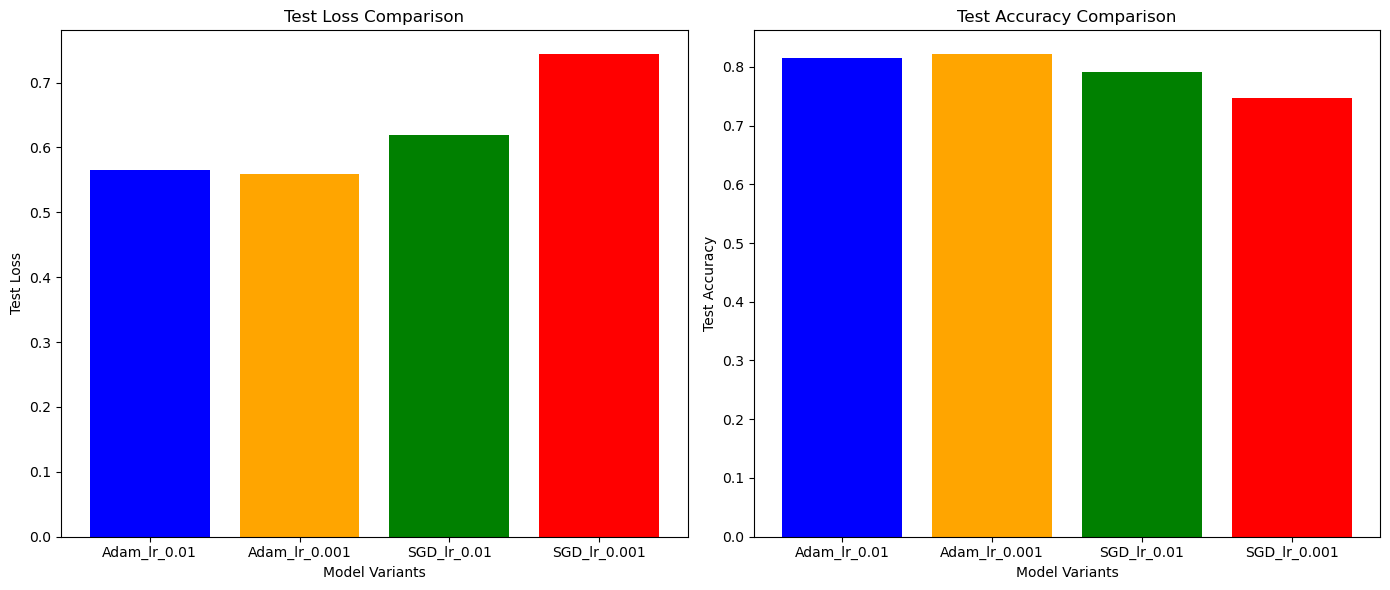

In [16]:
import matplotlib.pyplot as plt

results = {
    "Adam_lr_0.01": {"Loss": 0.5659, "Accuracy": 0.8144},
    "Adam_lr_0.001": {"Loss": 0.5589, "Accuracy": 0.8212},
    "SGD_lr_0.01": {"Loss": 0.6186, "Accuracy": 0.7908},
    "SGD_lr_0.001": {"Loss": 0.7435, "Accuracy": 0.7476}
}


labels = list(results.keys())
losses = [results[label]["Loss"] for label in labels]
accuracies = [results[label]["Accuracy"] for label in labels]


plt.figure(figsize=(14, 6))

# curve plot
plt.subplot(1, 2, 1)
plt.bar(labels, losses, color=["blue", "orange", "green", "red"])
plt.xlabel("Model Variants")
plt.ylabel("Test Loss")
plt.title("Test Loss Comparison")

# acc plot
plt.subplot(1, 2, 2)
plt.bar(labels, accuracies, color=["blue", "orange", "green", "red"])
plt.xlabel("Model Variants")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Comparison")

plt.tight_layout()
plt.show()



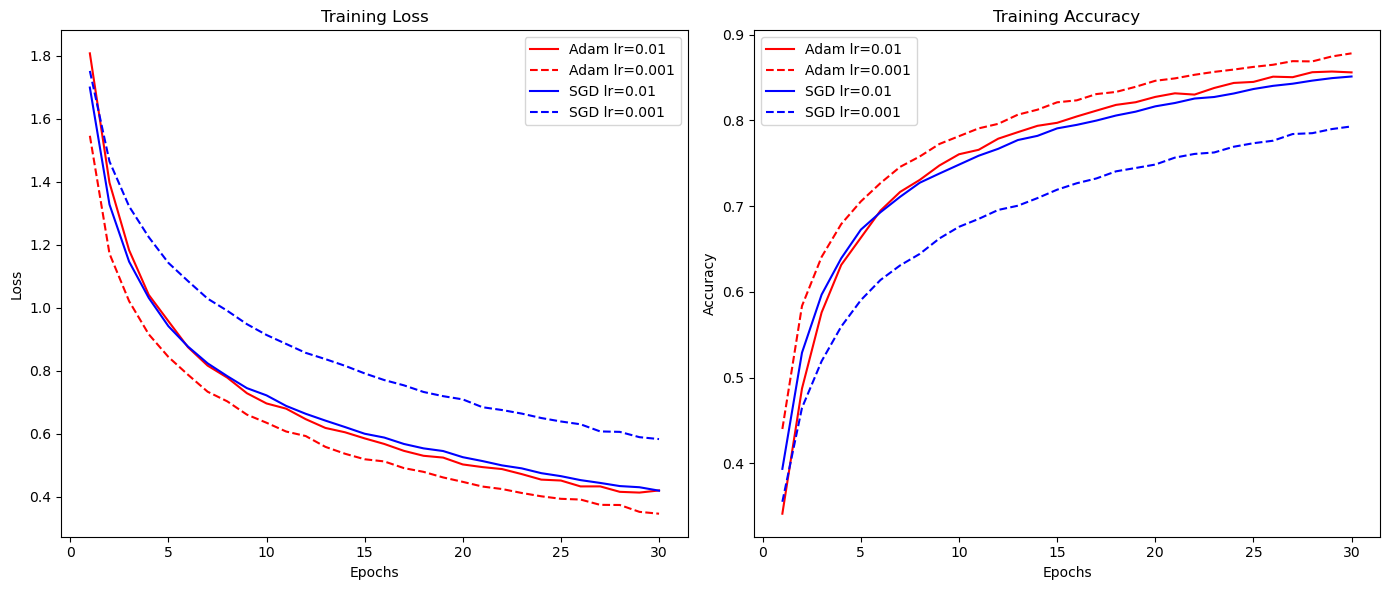

In [17]:
import matplotlib.pyplot as plt


adam_lr_0_01_loss = [1.8084, 1.3975, 1.1830, 1.0412, 0.9576, 0.8747, 0.8163, 0.7782, 0.7287, 0.6961,
                     0.6796, 0.6461, 0.6183, 0.6045, 0.5851, 0.5674, 0.5455, 0.5298, 0.5241, 0.5023,
                     0.4939, 0.4876, 0.4717, 0.4541, 0.4512, 0.4325, 0.4326, 0.4153, 0.4129, 0.4197]
adam_lr_0_01_acc = [0.3413, 0.4873, 0.5760, 0.6315, 0.6632, 0.6948, 0.7166, 0.7306, 0.7474, 0.7605,
                    0.7657, 0.7787, 0.7863, 0.7937, 0.7972, 0.8046, 0.8114, 0.8181, 0.8212, 0.8274,
                    0.8316, 0.8301, 0.8378, 0.8437, 0.8449, 0.8510, 0.8504, 0.8562, 0.8570, 0.8560]


adam_lr_0_001_loss = [1.5465, 1.1720, 1.0211, 0.9158, 0.8440, 0.7873, 0.7334, 0.7028, 0.6606, 0.6348,
                      0.6069, 0.5925, 0.5582, 0.5363, 0.5188, 0.5119, 0.4907, 0.4788, 0.4610, 0.4470,
                      0.4321, 0.4242, 0.4117, 0.4011, 0.3931, 0.3908, 0.3739, 0.3735, 0.3517, 0.3458]
adam_lr_0_001_acc = [0.4401, 0.5836, 0.6408, 0.6791, 0.7055, 0.7269, 0.7458, 0.7579, 0.7725, 0.7816,
                     0.7907, 0.7960, 0.8067, 0.8125, 0.8211, 0.8234, 0.8307, 0.8332, 0.8392, 0.8462,
                     0.8490, 0.8532, 0.8566, 0.8593, 0.8624, 0.8649, 0.8691, 0.8688, 0.8746, 0.8782]


sgd_lr_0_01_loss = [1.6997, 1.3282, 1.1466, 1.0315, 0.9417, 0.8768, 0.8235, 0.7829, 0.7448, 0.7218,
                    0.6883, 0.6632, 0.6416, 0.6211, 0.5999, 0.5877, 0.5674, 0.5534, 0.5449, 0.5254,
                    0.5131, 0.4993, 0.4899, 0.4746, 0.4651, 0.4525, 0.4436, 0.4336, 0.4299, 0.4190]
sgd_lr_0_01_acc = [0.3936, 0.5291, 0.5968, 0.6392, 0.6726, 0.6929, 0.7109, 0.7273, 0.7380, 0.7484,
                   0.7588, 0.7669, 0.7771, 0.7820, 0.7907, 0.7948, 0.7998, 0.8057, 0.8102, 0.8164,
                   0.8203, 0.8255, 0.8273, 0.8314, 0.8366, 0.8403, 0.8428, 0.8464, 0.8493, 0.8512]


sgd_lr_0_001_loss = [1.7525, 1.4649, 1.3222, 1.2246, 1.1428, 1.0849, 1.0291, 0.9906, 0.9481, 0.9137,
                     0.8852, 0.8568, 0.8370, 0.8157, 0.7916, 0.7704, 0.7537, 0.7326, 0.7192, 0.7090,
                     0.6842, 0.6752, 0.6639, 0.6498, 0.6388, 0.6299, 0.6072, 0.6058, 0.5890, 0.5829]
sgd_lr_0_001_acc = [0.3552, 0.4648, 0.5192, 0.5596, 0.5904, 0.6139, 0.6309, 0.6443, 0.6623, 0.6759,
                    0.6851, 0.6956, 0.7005, 0.7094, 0.7192, 0.7267, 0.7323, 0.7406, 0.7445, 0.7485,
                    0.7566, 0.7609, 0.7626, 0.7693, 0.7734, 0.7763, 0.7841, 0.7851, 0.7899, 0.7930]


epochs = range(1, 31)

plt.figure(figsize=(14, 6))

# loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, adam_lr_0_01_loss, 'r-', label='Adam lr=0.01')
plt.plot(epochs, adam_lr_0_001_loss, 'r--', label='Adam lr=0.001')
plt.plot(epochs, sgd_lr_0_01_loss, 'b-', label='SGD lr=0.01')
plt.plot(epochs, sgd_lr_0_001_loss, 'b--', label='SGD lr=0.001')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, adam_lr_0_01_acc, 'r-', label='Adam lr=0.01')
plt.plot(epochs, adam_lr_0_001_acc, 'r--', label='Adam lr=0.001')
plt.plot(epochs, sgd_lr_0_01_acc, 'b-', label='SGD lr=0.01')
plt.plot(epochs, sgd_lr_0_001_acc, 'b--', label='SGD lr=0.001')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
